# Inception resnet

Paper: [https://arxiv.org/pdf/1602.07261v2.pdf](https://arxiv.org/pdf/1602.07261v2.pdf)

Kiến trúc của Inception resnet v1 và v2:

![](../img/inception_resnet_v2.png)

Trong đó các block `Inception resnet` và `Stem` được thể hiện như sau:

## 1. Inception resnet v1

### a) Stem

![](../img/inception_resnet_v1_4.png)

### b) Inception-resnet-A

![](../img/inception_resnet_v1_1.png)

### c) Reduction-A

![](../img/inception_resnet_v1_6.png)

### d) Inception-resnet-B

![](../img/inception_resnet_v1_2.png)

### e) Reduction-B

![](../img/inception_resnet_v1_5.png)

### f) Inception-resnet-C

![](../img/inception_resnet_v1_3.png)

## 2. Inception resnet v2

### a) Stem

![](../img/inception_resnet_v2_1.png)

### b) Inception-resnet-A

![](../img/inception_resnet_v2_2.png)

### c) Reduction-A

![](../img/inception_resnet_v2_6.png)

### d) Inception-resnet-B

![](../img/inception_resnet_v2_3.png)

### e) Reduction-B

![](../img/inception_resnet_v2_5.png)

### f) Inception-resnet-C

![](../img/inception_resnet_v2_4.png)



![](../img/table_1.png)

## 3. Implement inception-resnet-v2 pretrained

In [1]:
from __future__ import print_function, division, absolute_import
import torch.utils.model_zoo as model_zoo
import sys
import urllib.request
import ssl
import torch
import torchvision
from torch.optim import lr_scheduler
import torch.nn as nn 
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import InterpolationMode
import torchvision.transforms.functional as TF
from torchsummary import summary
import numpy as np
import cv2
import os
import time
import copy
import imutils
from PIL import Image
import shutil
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import matplotlib.pyplot as plt
from tqdm import tqdm

ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Setup device

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Hyper parameters

In [4]:
num_epochs = 100
batch_size = 4
learning_rate = 1e-3

## Load data

In [5]:
# TRAIN_DIR = './drive/MyDrive/ml_isofh/data/brain_tumor_dataset/TRAIN'
# TEST_DIR = './drive/MyDrive/ml_isofh/data/brain_tumor_dataset/TEST'
# # VAL_DIR = './drive/MyDrive/ml_isofh/data/brain_tumor_dataset/VAL'
TRAIN_DIR = './drive/MyDrive/ml_isofh/data/brain_tumor_2/TRAIN'
TEST_DIR = './drive/MyDrive/ml_isofh/data/brain_tumor_2/TEST'
# VAL_DIR = './drive/MyDrive/ml_isofh/data/brain_tumor_dataset/VAL'
IMG_SIZE = (224, 224)

# Take Mean and std
samples_set = datasets.ImageFolder(TRAIN_DIR, transform=transforms.Resize((224, 224)))

def readToNumpy(imagesSet):
    listImgs = []
    for img_path in imagesSet:
        img = cv2.imread(img_path[0])
        listImgs.append(cv2.resize(img, (224, 224), interpolation = cv2.INTER_AREA))
    return np.array(listImgs)

listImgs = readToNumpy(samples_set.imgs)

MEAN = (listImgs/255.0).mean((0,1,2))
STD = (listImgs /255.0).std((0,1,2))
MEAN,STD=[0.485, 0.456, 0.406],[0.229, 0.224, 0.225]
MEAN, STD

([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [6]:
# This line of code is to auto completion of code using key "Tab". Just make coding faster ^^! 
# I read from this post "https://www.kaggle.com/getting-started/51622"
%config Completer.use_jedi = False

## Custom Dataset


In [7]:
class BrainTumor(Dataset):
    def __init__(self, root, transforms=None):
        imageData = datasets.ImageFolder(root)
        self.n_samples = len(imageData.imgs)  
        self.data = np.array([cv2.imread(img_path[0]) for img_path in imageData.imgs])
        self.targets = np.array(imageData.targets)
        self.classes = imageData.classes
        self.transforms = transforms
    def __len__(self):
        return self.n_samples
    def __getitem__(self, index):
        x = self.data[index]
        # print(self.data[index].shape, self.targets[index].shape)
        if self.transforms:
            x = self.transforms(x)
            # change = self.transforms(self.data[index])
            # sample = change, self.targets[index]
        return x,  self.targets[index]

In [8]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

## Preprocessing data

In [9]:

class ImageEnhanced(object):
    """_summary_
    transform to enhanced image quality for prediction 
    """
    def __init__(self):
        pass
    def __call__(self, img ,add_pixels_value = 0):
        
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)
        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 60, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)
        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)
        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])
        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        return Image.fromarray(new_img)
            
# class Flip(object):
#     def __init__(self)    
# Data trasform

# Crop only
transformsImg = transforms.Compose([
    ImageEnhanced(),
    transforms.ToTensor(),
    transforms.Resize((299, 299), interpolation=InterpolationMode.BICUBIC),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomResizedCrop((299,299),scale=(0.8,1.0),ratio=(0.9,1.1)),
    transforms.Normalize(MEAN, STD)
])

test_transform = transforms.Compose([
    ImageEnhanced(),
    transforms.ToTensor(),
    transforms.Resize((299, 299), interpolation=InterpolationMode.BICUBIC),
    transforms.Normalize(MEAN, STD)
])
train_transform = transforms.Compose([
    ImageEnhanced(),
    transforms.ToTensor(),
    transforms.Resize((299, 299), interpolation=InterpolationMode.BICUBIC),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    # transforms.ColorJitter(brightness=[0.1, 1.5]),
    # transforms.RandomAffine(degrees=40, translate=None, shear=0.1, resample=False, fillcolor=0),
    # transforms.ColorJitter(brightness=[0.1, 1.5]),
    # transforms.RandomAffine(),
    transforms.RandomResizedCrop((299,299),scale=(0.8,1.0)),
    transforms.Normalize(MEAN, STD)
])

# load data
train_dataset = BrainTumor(root=TRAIN_DIR, transforms=train_transform)
test_dataset = BrainTumor(TEST_DIR, transforms=test_transform)
# val_dataset = BrainTumor(VAL_DIR, transforms=test_transform)

# data shape
print(f"train set :{train_dataset.data.shape}")
print(f"test set: {test_dataset.data.shape}")
# print(f"val set: {val_dataset.data.shape}")
# # data loader
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size, drop_last=False)
# val_loader = DataLoader(val_dataset, shuffle=True, batch_size=batch_size, drop_last=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """


train set :(227,)
test set: (26,)


## Image visualization

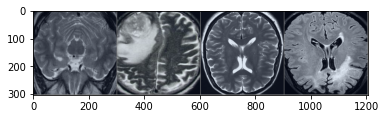

Yes          Yes          No           No          


In [10]:
classes = ('No', 'Yes')
NUM_IMGS = batch_size

show_samples = iter(train_loader)
images,labels = show_samples.next()

imgs = torchvision.utils.make_grid(images, normalize=True, pad_value=0.5)

# Convert images to a readable numpy for plt
imgs = imgs.numpy()

# Transform imgs to an array of images
imgs = imgs.transpose((1,2,0))

# Show images
plt.imshow(imgs)
plt.show()

print(' '.join(f'{classes[labels[j]]:12s}' for j in range(NUM_IMGS)))

## Pre-trained model

In [11]:


__all__ = ['InceptionResNetV2', 'inceptionresnetv2']

pretrained_settings = {
    'inceptionresnetv2': {
        'imagenet': {
            'url': 'http://data.lip6.fr/cadene/pretrainedmodels/inceptionresnetv2-520b38e4.pth',
            'input_space': 'RGB',
            'input_size': [3, 299, 299],
            'input_range': [0, 1],
            'mean': [0.5, 0.5, 0.5],
            'std': [0.5, 0.5, 0.5],
            'num_classes': 1000
        },
        'imagenet+background': {
            'url': 'http://data.lip6.fr/cadene/pretrainedmodels/inceptionresnetv2-520b38e4.pth',
            'input_space': 'RGB',
            'input_size': [3, 299, 299],
            'input_range': [0, 1],
            'mean': [0.5, 0.5, 0.5],
            'std': [0.5, 0.5, 0.5],
            'num_classes': 1001
        }
    }
}


class BasicConv2d(nn.Module):

    def __init__(self, in_planes, out_planes, kernel_size, stride, padding=0):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_planes, out_planes,
                              kernel_size=kernel_size, stride=stride,
                              padding=padding, bias=False) # verify bias false
        self.bn = nn.BatchNorm2d(out_planes,
                                 eps=0.001, # value found in tensorflow
                                 momentum=0.1, # default pytorch value
                                 affine=True)
        self.relu = nn.ReLU(inplace=False)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


class Mixed_5b(nn.Module):

    def __init__(self):
        super(Mixed_5b, self).__init__()

        self.branch0 = BasicConv2d(192, 96, kernel_size=1, stride=1)

        self.branch1 = nn.Sequential(
            BasicConv2d(192, 48, kernel_size=1, stride=1),
            BasicConv2d(48, 64, kernel_size=5, stride=1, padding=2)
        )

        self.branch2 = nn.Sequential(
            BasicConv2d(192, 64, kernel_size=1, stride=1),
            BasicConv2d(64, 96, kernel_size=3, stride=1, padding=1),
            BasicConv2d(96, 96, kernel_size=3, stride=1, padding=1)
        )

        self.branch3 = nn.Sequential(
            nn.AvgPool2d(3, stride=1, padding=1, count_include_pad=False),
            BasicConv2d(192, 64, kernel_size=1, stride=1)
        )

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        out = torch.cat((x0, x1, x2, x3), 1)
        return out


class Block35(nn.Module):

    def __init__(self, scale=1.0):
        super(Block35, self).__init__()

        self.scale = scale

        self.branch0 = BasicConv2d(320, 32, kernel_size=1, stride=1)

        self.branch1 = nn.Sequential(
            BasicConv2d(320, 32, kernel_size=1, stride=1),
            BasicConv2d(32, 32, kernel_size=3, stride=1, padding=1)
        )

        self.branch2 = nn.Sequential(
            BasicConv2d(320, 32, kernel_size=1, stride=1),
            BasicConv2d(32, 48, kernel_size=3, stride=1, padding=1),
            BasicConv2d(48, 64, kernel_size=3, stride=1, padding=1)
        )

        self.conv2d = nn.Conv2d(128, 320, kernel_size=1, stride=1)
        self.relu = nn.ReLU(inplace=False)

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        out = torch.cat((x0, x1, x2), 1)
        out = self.conv2d(out)
        out = out * self.scale + x
        out = self.relu(out)
        return out


class Mixed_6a(nn.Module):

    def __init__(self):
        super(Mixed_6a, self).__init__()

        self.branch0 = BasicConv2d(320, 384, kernel_size=3, stride=2)

        self.branch1 = nn.Sequential(
            BasicConv2d(320, 256, kernel_size=1, stride=1),
            BasicConv2d(256, 256, kernel_size=3, stride=1, padding=1),
            BasicConv2d(256, 384, kernel_size=3, stride=2)
        )

        self.branch2 = nn.MaxPool2d(3, stride=2)

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        out = torch.cat((x0, x1, x2), 1)
        return out


class Block17(nn.Module):

    def __init__(self, scale=1.0):
        super(Block17, self).__init__()

        self.scale = scale

        self.branch0 = BasicConv2d(1088, 192, kernel_size=1, stride=1)

        self.branch1 = nn.Sequential(
            BasicConv2d(1088, 128, kernel_size=1, stride=1),
            BasicConv2d(128, 160, kernel_size=(1,7), stride=1, padding=(0,3)),
            BasicConv2d(160, 192, kernel_size=(7,1), stride=1, padding=(3,0))
        )

        self.conv2d = nn.Conv2d(384, 1088, kernel_size=1, stride=1)
        self.relu = nn.ReLU(inplace=False)

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        out = torch.cat((x0, x1), 1)
        out = self.conv2d(out)
        out = out * self.scale + x
        out = self.relu(out)
        return out


class Mixed_7a(nn.Module):

    def __init__(self):
        super(Mixed_7a, self).__init__()

        self.branch0 = nn.Sequential(
            BasicConv2d(1088, 256, kernel_size=1, stride=1),
            BasicConv2d(256, 384, kernel_size=3, stride=2)
        )

        self.branch1 = nn.Sequential(
            BasicConv2d(1088, 256, kernel_size=1, stride=1),
            BasicConv2d(256, 288, kernel_size=3, stride=2)
        )

        self.branch2 = nn.Sequential(
            BasicConv2d(1088, 256, kernel_size=1, stride=1),
            BasicConv2d(256, 288, kernel_size=3, stride=1, padding=1),
            BasicConv2d(288, 320, kernel_size=3, stride=2)
        )

        self.branch3 = nn.MaxPool2d(3, stride=2)

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        out = torch.cat((x0, x1, x2, x3), 1)
        return out


class Block8(nn.Module):

    def __init__(self, scale=1.0, noReLU=False):
        super(Block8, self).__init__()

        self.scale = scale
        self.noReLU = noReLU

        self.branch0 = BasicConv2d(2080, 192, kernel_size=1, stride=1)

        self.branch1 = nn.Sequential(
            BasicConv2d(2080, 192, kernel_size=1, stride=1),
            BasicConv2d(192, 224, kernel_size=(1,3), stride=1, padding=(0,1)),
            BasicConv2d(224, 256, kernel_size=(3,1), stride=1, padding=(1,0))
        )

        self.conv2d = nn.Conv2d(448, 2080, kernel_size=1, stride=1)
        if not self.noReLU:
            self.relu = nn.ReLU(inplace=False)

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        out = torch.cat((x0, x1), 1)
        out = self.conv2d(out)
        out = out * self.scale + x
        if not self.noReLU:
            out = self.relu(out)
        return out


class InceptionResNetV2(nn.Module):

    def __init__(self, num_classes=1001):
        super(InceptionResNetV2, self).__init__()
        # Special attributs
        self.input_space = None
        self.input_size = (299, 299, 3)
        self.mean = None
        self.std = None
        # Modules
        self.conv2d_1a = BasicConv2d(3, 32, kernel_size=3, stride=2)
        self.conv2d_2a = BasicConv2d(32, 32, kernel_size=3, stride=1)
        self.conv2d_2b = BasicConv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.maxpool_3a = nn.MaxPool2d(3, stride=2)
        self.conv2d_3b = BasicConv2d(64, 80, kernel_size=1, stride=1)
        self.conv2d_4a = BasicConv2d(80, 192, kernel_size=3, stride=1)
        self.maxpool_5a = nn.MaxPool2d(3, stride=2)
        self.mixed_5b = Mixed_5b()
        self.repeat = nn.Sequential(
            Block35(scale=0.17),
            Block35(scale=0.17),
            Block35(scale=0.17),
            Block35(scale=0.17),
            Block35(scale=0.17),
            Block35(scale=0.17),
            Block35(scale=0.17),
            Block35(scale=0.17),
            Block35(scale=0.17),
            Block35(scale=0.17)
        )
        self.mixed_6a = Mixed_6a()
        self.repeat_1 = nn.Sequential(
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10)
        )
        self.mixed_7a = Mixed_7a()
        self.repeat_2 = nn.Sequential(
            Block8(scale=0.20),
            Block8(scale=0.20),
            Block8(scale=0.20),
            Block8(scale=0.20),
            Block8(scale=0.20),
            Block8(scale=0.20),
            Block8(scale=0.20),
            Block8(scale=0.20),
            Block8(scale=0.20)
        )
        self.block8 = Block8(noReLU=True)
        self.conv2d_7b = BasicConv2d(2080, 1536, kernel_size=1, stride=1)
        self.avgpool_1a = nn.AvgPool2d(8, count_include_pad=False)
        self.last_linear = nn.Linear(1536, num_classes)
        

    def features(self, input):
        x = self.conv2d_1a(input)
        x = self.conv2d_2a(x)
        x = self.conv2d_2b(x)
        x = self.maxpool_3a(x)
        x = self.conv2d_3b(x)
        x = self.conv2d_4a(x)
        x = self.maxpool_5a(x)
        x = self.mixed_5b(x)
        x = self.repeat(x)
        x = self.mixed_6a(x)
        x = self.repeat_1(x)
        x = self.mixed_7a(x)
        x = self.repeat_2(x)
        x = self.block8(x)
        x = self.conv2d_7b(x)
        return x

    def logits(self, features):
        x = self.avgpool_1a(features)
        x = x.view(x.size(0), -1)
        x = self.last_linear(x)
        return x

    def forward(self, input):
        x = self.features(input)
        x = self.logits(x)
        return x

def inceptionresnetv2(num_classes=1000, pretrained='imagenet'):
    r"""InceptionResNetV2 model architecture from the
    `"InceptionV4, Inception-ResNet..." <https://arxiv.org/abs/1602.07261>`_ paper.
    """
    if pretrained:
        settings = pretrained_settings['inceptionresnetv2'][pretrained]
        assert num_classes == settings['num_classes'], \
            "num_classes should be {}, but is {}".format(settings['num_classes'], num_classes)

        # both 'imagenet'&'imagenet+background' are loaded from same parameters
        model = InceptionResNetV2(num_classes=1001)
        model.load_state_dict(model_zoo.load_url(settings['url']))

        if pretrained == 'imagenet':
            new_last_linear = nn.Linear(1536, 1000)
            new_last_linear.weight.data = model.last_linear.weight.data[1:]
            new_last_linear.bias.data = model.last_linear.bias.data[1:]
            model.last_linear = new_last_linear

        model.input_space = settings['input_space']
        model.input_size = settings['input_size']
        model.input_range = settings['input_range']

        model.mean = settings['mean']
        model.std = settings['std']
    else:
        model = InceptionResNetV2(num_classes=num_classes)
    return model

'''
TEST
Run this code with:
```
cd $HOME/pretrained-models.pytorch
python -m pretrainedmodels.inceptionresnetv2
```
'''
# Using availabel VGG16
model_ft = inceptionresnetv2(num_classes=1000, pretrained='imagenet').to(device)
print(model_ft.parameters())
# freeze convolution weights
for param in model_ft.parameters():
    param.requires_grad = False

# Modify last fc layer
num_inputs = model_ft.last_linear.in_features
model_ft.last_linear = nn.Sequential(
    nn.Dropout(0.1),
    nn.Linear(num_inputs, 1000),
    nn.ReLU(),
    nn.Linear(1000, 512),
    nn.ReLU(),
    nn.Linear(512,448),
    nn.ReLU(),
    nn.Linear(448, 320),
    nn.ReLU(),
    nn.Linear(320, 2)
).to(device)
# Model summary
summary(model_ft, (3, 299, 299))

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model_ft.last_linear.parameters(),
                            lr=learning_rate,
                            weight_decay=0.0005)
exp_lr_scheduler = lr_scheduler.MultiStepLR(optimizer, 
                                           milestones=[20,40,60,80, 100], 
                                           gamma=0.2)




Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/inceptionresnetv2-520b38e4.pth" to /root/.cache/torch/hub/checkpoints/inceptionresnetv2-520b38e4.pth


  0%|          | 0.00/213M [00:00<?, ?B/s]

<generator object Module.parameters at 0x7f1e787e6450>
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 149, 149]             864
       BatchNorm2d-2         [-1, 32, 149, 149]              64
              ReLU-3         [-1, 32, 149, 149]               0
       BasicConv2d-4         [-1, 32, 149, 149]               0
            Conv2d-5         [-1, 32, 147, 147]           9,216
       BatchNorm2d-6         [-1, 32, 147, 147]              64
              ReLU-7         [-1, 32, 147, 147]               0
       BasicConv2d-8         [-1, 32, 147, 147]               0
            Conv2d-9         [-1, 64, 147, 147]          18,432
      BatchNorm2d-10         [-1, 64, 147, 147]             128
             ReLU-11         [-1, 64, 147, 147]               0
      BasicConv2d-12         [-1, 64, 147, 147]               0
        MaxPool2d-13           [-1, 64, 73, 73] 

In [13]:
# dataloaders = {'TRAIN':train_loader, 'VAL':val_loader}
# dataset_sizes = {'TRAIN':train_dataset.data.shape[0], 'VAL':test_dataset.data.shape[0]}
min_valid_loss = np.inf
print(min_valid_loss)
# validation function
def validate(model, test_dataloader):
    global min_valid_loss
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    n_samples = 0
    for idx, (images, labels) in enumerate(test_dataloader):
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        loss = criterion(output, labels)
        
        val_running_loss += loss.item()
        _, preds = torch.max(output, 1)
        val_running_correct += (preds == labels).sum().item()
        n_samples += labels.size(0)
        
        if min_valid_loss > loss.item():
          print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{loss.item():.6f}) \t Saving The Model')
          min_valid_loss = loss.item()
          torch.save(model.state_dict(), 'saved_model.pth')
    val_loss = val_running_loss/n_samples
    val_accuracy = 100. * val_running_correct/n_samples
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}')

    return val_loss, val_accuracy

# training function
def fit(model, train_dataloader, epoch, epochs):
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    n_samples = 0
    with tqdm(train_dataloader, unit='batch') as tepoch:
      for (images, labels) in tepoch:
          tepoch.set_description(f"Epoch [{epoch}/{epochs}]")
          images, labels = images.to(device), labels.to(device)
          optimizer.zero_grad()
          output = model(images)
          loss = criterion(output, labels)
          train_running_loss += loss.item()
          _, preds = torch.max(output, 1)
          correct = (preds == labels).sum().item()
          train_running_correct += (preds == labels).sum().item()
          loss.backward()
          optimizer.step()
          n_samples += labels.size(0)
          tepoch.set_postfix(loss=loss.item()/labels.size(0), accuracy=100.*correct/labels.size(0))
      train_loss = train_running_loss/n_samples
      train_accuracy = 100. * train_running_correct/n_samples
      # print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}')
    
    return train_loss, train_accuracy

inf


In [14]:
train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []
start = time.time()
for epoch in range(num_epochs):
    train_epoch_loss, train_epoch_accuracy = fit(model_ft, train_loader, epoch, num_epochs)
    exp_lr_scheduler.step()
    # val_epoch_loss, val_epoch_accuracy = validate(model_ft, test_loader)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    # val_loss.append(val_epoch_loss)
    # val_accuracy.append(val_epoch_accuracy)
    # print("-"*10)
end = time.time()
print((end-start)/60, 'minutes')
torch.save(model_ft.state_dict(), 'saved_model.pth')
print("Model saved!")


Epoch [99/100]: 100%|██████████| 56/56 [00:05<00:00, 10.83batch/s, accuracy=100, loss=0.0205]


8.775422565142314 minutes
Model saved!


Miss classifier images


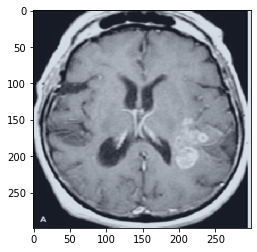

No          
Accuracy 96.15384615384616 %


In [15]:
miss_classifier = []
miss_classifier_labels = []
count = 0
model_ft.load_state_dict(torch.load("saved_model.pth"))
model_ft.eval()
with torch.no_grad():
  n_correct = 0
  n_samples = 0
  for (images, labels) in test_loader:
    images = images.to(device)
    labels = labels.to(device)

    outputs = model_ft(images)
    _, pred = torch.max(outputs, 1)

    n_correct += (pred == labels).sum().item()
    ####### Miss classifier####
    a = pred == labels
    miss_classifier_idx = (a == False).nonzero(as_tuple=True)[0]
    for idx in miss_classifier_idx:
      count +=1
      miss_classifier.append(images[idx])
      miss_classifier_labels.append(pred[idx])
    # #######################33
    n_samples += labels.size(0)

imgs = torchvision.utils.make_grid(miss_classifier, normalize=True, pad_value=0.5)

# Convert images to a readable numpy for plt
imgs = torch.Tensor.cpu(imgs)
imgs = imgs.numpy()

# Transform imgs to an array of images
imgs = imgs.transpose((1,2,0))

# Show images
plt.imshow(imgs)
print("Miss classifier images")
plt.show()
print(' '.join(f'{classes[miss_classifier_labels[j]]:12s}' for j in range(len(miss_classifier_labels))))
print(f"Accuracy {n_correct / n_samples * 100} %")

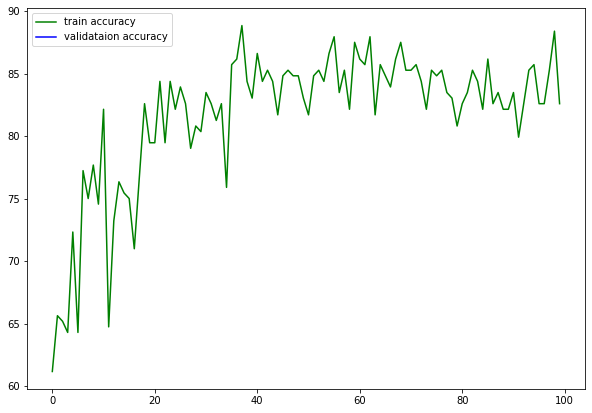

In [16]:
plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validataion accuracy')
plt.legend()
plt.savefig('accuracy.png')
plt.show()

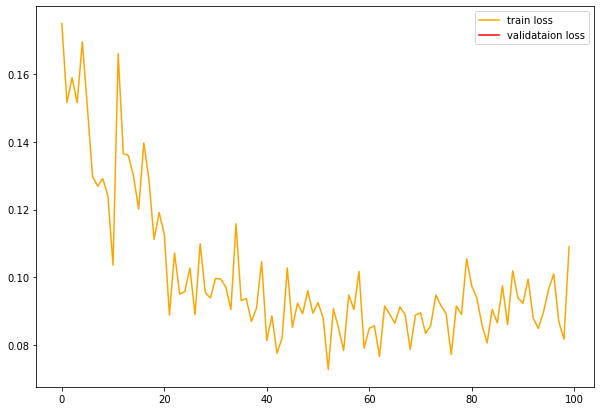

In [17]:
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.legend()
plt.savefig('loss.png')
plt.show()